In [156]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem import rdMolEnumerator
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolfiles as rdfiles
from rdkit.Chem import PandasTools
import pandas as pd
import matplotlib.pyplot as plt
from vina import Vina
import py3Dmol
from meeko import MoleculePreparation
import os
from tqdm import tqdm

from pymol import cmd
from openbabel import pybel
from ipywidgets import interact,fixed,IntSlider
import ipywidgets as widgets
from IPython.display import display

In [2]:
conformer_path = 'output_conf/'

# Molecular enumeration 


If the core is generated as a regio isomer using eg. MarvinSketch, the input -mol2 file is here generated as several regio-isomers which are then sanitised and can be used for reaction based enumeration

In [166]:
Regio_mol = Chem.MolFromMolFile('dipeptide.mol')
Regio_enum = rdMolEnumerator.Enumerate(Regio_mol)

In [167]:
#Sanitise generated regio isomers
from rdkit.Chem import rdFMCS
def align_bundle_coords(bndl):
    '''Sanitises generated regio isomers'''
    ps = rdFMCS.MCSParameters()
    for m in bndl:
        Chem.SanitizeMol(m)
    mcs = rdFMCS.FindMCS(bndl,completeRingsOnly=True)
    q = Chem.MolFromSmarts(mcs.smartsString)
    rdDepictor.Compute2DCoords(q)
    for m in bndl:
        rdDepictor.GenerateDepictionMatching2DStructure(m,q)

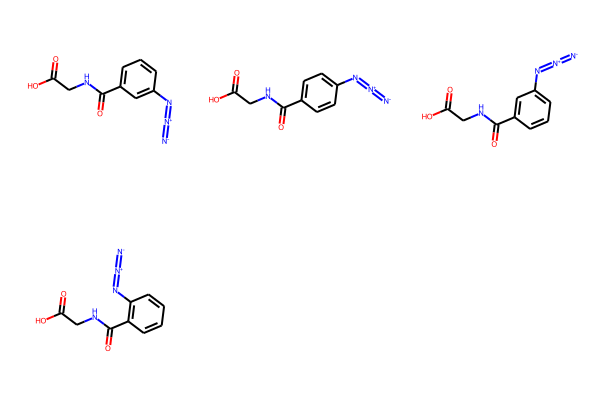

In [170]:
#Call molecular sanitation
align_bundle_coords(Regio_enum)


Regio_isomers = []
for i in Regio_enum:
    Chem.MolToSmiles(i)
    Regio_isomers.append(i)
    
Draw.MolsToGridImage(Regio_enum)

# Import core, reactants, and reactant library

The molecules of interest can be generated individualy as SMILES or imported from a SMILES file. 

The provided reaction library is a Pandas DataFrame. It is accessed as 


In [33]:
Library_alc = rdfiles.SmilesMolSupplier('Alcohols.smi') #Read input file with all reactants
Library_amine = rdfiles.SmilesMolSupplier('Amine.smi')
Library_alkynes = rdfiles.SmilesMolSupplier('alkynes.smi')

reaction_library = pd.read_csv('Reaction_library_2.csv', index_col='ReactionName')
reaction_library

,ReactionSMARTS
ReactionName,
Primary alc ox,[CH2:1]-O >> [C:1]=O
Amide coupling,[C:1](=[O:2])O.[N:3] >> [C:1](=[O:2])[N:3]
Diels-Alder,'[C:1]=[C:2]-[C:3]=[C:4].[C:5]=[C:6] >> [C:5]-...
4Click,[N:1]=[N+1:2]=[N-1:3].[CH:4]#[C:5]>>[N:1]-1-[C...
Esterification,[C:1](=[O:2])O.[O:3] >> [C:1](=[O:2])[O:3]


# Single molecule reactions/modification

Here, the input only undergoes an intramolecular modification i.e no additional reactant is added.

In [6]:
def unimolecular_rxn(SM, reaction_SMIRKS):
    '''Input the reactant and the reaction SMIRKS and react each reactant according to the defined SMARTS reaction in the function'''

    rxn2 = AllChem.ReactionFromSmarts (reaction_SMIRKS)
    product = rxn2.RunReactants([SM,])
    
    resulting_smile_list = []
    try:
        for i in range(len(product)):
            resulting_smile = Chem.MolToSmiles(product[i][0])
            resulting_smile_list.append(resulting_smile)
    except:
        pass
    return resulting_smile_list
    

# React two compound 

Here, two compounds are allowed to react but where one is defined as the core and the other reactant is itterated over an input list of smiles.

In [34]:
def bimolecular_rxn(mol1, mol2, reaction):
    '''The function takes two input arguments where one is defined as a molecular core to be enumarated'''
    rxn3 = AllChem.ReactionFromSmarts (reaction)
    products = rxn3.RunReactants ([mol1, mol2])
    resulting_smile_list = []
    try:
        for i in range(len(products)):
            resulting_smile = Chem.MolToSmiles(products[i][0])
            resulting_smile_list.append(resulting_smile)
    except:
        pass
    return resulting_smile_list

# Run reaction


## Single molecular enumeration

In [ ]:
reaction = reaction_library.ReactionSMARTS['Primary alc ox'] #Define the reaction type
reaction

products_unimolecular = []
for i in Library_alc: #Pass the name of the input library
    prod = unimolecular_rxn(i, reaction)

    for mol in prod:
        product = Chem.MolFromSmiles(mol)
        products.append(product)


### Reaction between one core and library

Run Click reaction between suger and azides

In [171]:
reaction_type = reaction_library.ReactionSMARTS["4Click"] #Define the reaction type from the reaction library
product_bimolecular = [] #List of enumerated molecules
Core = Chem.MolFromSmiles('O[C@@H]1[C@@H](O)[C@H](OCC2=CC=CC=C2)[C@H](C[C@H]1N=[N+]=[N-])C([O-])=O') #Define the molecular core

for i in Library_alkynes: #Read the .smi-file of reagents to be used for enumeration
    resulting_smiles = bimolecular_rxn(Core, i, reaction_type)
    
    for i in resulting_smiles:
        prod1 = Chem.MolFromSmiles(i)
        product_bimolecular.append(prod1)

# Draw.MolsToGridImage(product_bimolecular, maxMols=999) Uncomment to view reaction output

### Run reaction between a regio isomeric core and reaction library

Here the regio isomer generated above is looped over together with the specified reaction library.

In [12]:
prod_bimolecular_2 = []

for i in Regio_isomers:
    for j in Library_alkynes:
        output_prod = bimolecular_rxn(i, j, reaction_type)
        for mol_string in output_prod:
            prod = Chem.MolFromSmiles(mol_string)
            prod_bimolecular_2.append(prod)

# Molecular descriptors

By calculating molecular descriptors for the generated dataset, it is possible to run them against eg. Lipinki rule of five, soluability prediction etc. 

In [172]:
def descriptor_calc(mol):

    mwt = Descriptors.MolWt(mol)
    mol_logP = Descriptors.MolLogP(mol)
    HBD = Descriptors.NumHDonors(mol)
    HBA = Descriptors.NumHAcceptors(mol)
    Aromatic_rings = Descriptors.NumAromaticRings(mol)
    Rot_bonds = Descriptors.NumRotatableBonds(mol)
    TPSA = Descriptors.TPSA(mol)
    Het_atoms = Descriptors.NumHeteroatoms(mol)
    arom_atm = [mol.GetAtomWithIdx(i).GetIsAromatic() for i in range(mol.GetNumAtoms())]
    a = arom_atm.count(True)
    Heavy_atoms = Descriptors.HeavyAtomCount(mol)
    aromatic_prop = a / Heavy_atoms
    smiles = Chem.MolToSmiles(mol)
    return {'Mwt': mwt, 'clogP':mol_logP, 'HBD':HBD, 'HBA':HBA, 'Rotatable bonds':Rot_bonds, 'TPSA': TPSA, 'Hetero atoms': Het_atoms, 'Aromatic proportion': aromatic_prop, 'SMILES': smiles}

In [173]:
descriptors_list = []
for i in product_bimolecular:
    descriptors = descriptor_calc(i)

    descriptors_list.append(descriptors)
    
descriptors = pd.DataFrame(columns=['Mwt', 'clogP', 'HBD', 'HBA', 'Rotatable bonds', 'TPSA', 'Hetero atoms', 'Aromatic proportion', 'SMILES'])

for i in descriptors_list:
    descriptors.loc[len(descriptors)] = i


,Mwt,clogP,HBD,HBA,Rotatable bonds,TPSA,Hetero atoms,Aromatic proportion,SMILES,ROMol
0,362.362,-1.6115,3,9,6,140.76,9,0.423077,O=C([O-])[C@H]1C[C@@H](n2cc(CO)nn2)[C@H](O)[C@...,
1,490.493,-2.2955,5,11,11,212.95,13,0.314286,N[C@H](CCC(=O)NCc1cn([C@@H]2C[C@H](C(=O)[O-])[...,
2,449.440,-2.7869,5,11,9,204.08,12,0.343750,N[C@@](CO)(Cc1cn([C@@H]2C[C@H](C(=O)[O-])[C@@H...,
3,502.460,-2.3095,4,12,9,219.02,14,0.305556,NC(=O)NC(=O)/C=C/C(=O)OCc1cn([C@@H]2C[C@H](C(=...,
4,375.405,-1.3844,3,9,7,132.56,9,0.407407,CNCc1cn([C@@H]2C[C@H](C(=O)[O-])[C@@H](OCc3ccc...,
...,...,...,...,...,...,...,...,...,...,...
74,467.524,-1.6699,2,10,9,157.91,12,0.343750,CN(C)S(=O)(=O)CCc1cn([C@@H]2C[C@H](C(=O)[O-])[...,
75,429.417,-2.4868,3,13,7,190.15,13,0.516129,Nc1nnn(Cc2cn([C@@H]3C[C@H](C(=O)[O-])[C@@H](OC...,
76,503.532,-1.3473,4,11,8,181.30,12,0.305556,C[C@@H](C(=O)O)N1CCC(O)(c2cn([C@@H]3C[C@H](C(=...,
77,502.504,-2.5152,3,11,8,179.17,13,0.305556,O=C(NCC(=O)N1CCOCC1)c1cn([C@@H]2C[C@H](C(=O)[O...,

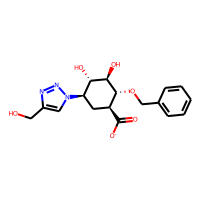
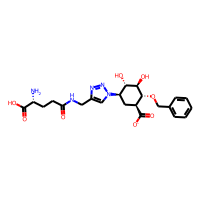
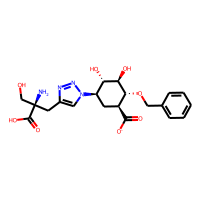
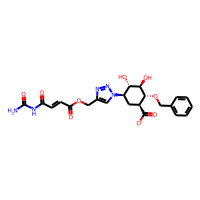
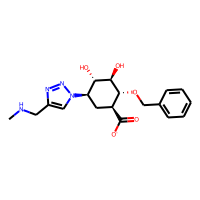
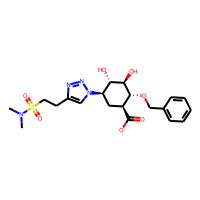
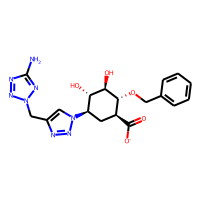
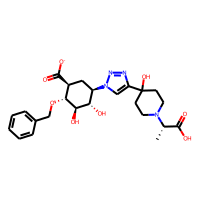
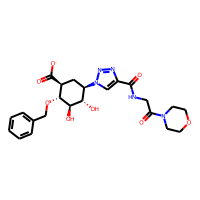
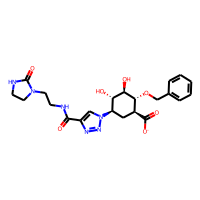

In [174]:
PandasTools.AddMoleculeColumnToFrame(descriptors, smilesCol='SMILES')
descriptors

# Generate 3D coordinates 

The dataset generated above must be converetd into usable 3D coordinates if it is going to be docked into an enzyme using eg. AutoDock Vina. The 3D coordinates are saved as .sdf-files if another docking program is prefered.

In [66]:
def conf_gen(mol_list):
    conformer_list = []
    for i in tqdm(mol_list):
        mol = Chem.AddHs(i)
        a = AllChem.EmbedMolecule(mol, useRandomCoords=True, maxAttempts = 10)
        if a == -1:
            continue
        AllChem.MMFFOptimizeMolecule(mol, mmffVariant = 'MMFF94', confId = 0)
        conformer_list.append(mol)
    return conformer_list

In [176]:
conformer = conf_gen(product_bimolecular)
print('{} conformers were generated. \n{} conformers could not be generted'.format(len(conformer), (len(product_bimolecular)-len(conformer))))

if os.path.exists(conformer_path) == True:
    pass
if os.path.exists(conformer_path) == False:
    os.makedirs(conformer_path)

with Chem.SDWriter('output_conf/TestLigands_new.sdf') as w:
    for m in conformer:
        w.write(m)

100%|███████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.49it/s]

78 conformers were generated. 
1 conformers could not be generted


# Visulize the 3D conformation 


In [70]:
def MolTo3DView(mol, size=(500, 500)):
    #style: 'line', 'stick', 'sphere', 'carton'
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(Chem.MolToMolBlock(mol))
    viewer.setStyle({'stick':{}})
    viewer.zoomTo()
    return viewer
def conf_viewer(molecule):
    molecule = conformer[molecule]
    return MolTo3DView(molecule).show()

In [177]:
interact(conf_viewer, molecule=widgets.IntSlider(min=0,max=len(conformer)-1, step=1))

interactive(children=(IntSlider(value=0, description='molecule', max=77), Output()), _dom_classes=('widget-int…

<function __main__.conf_viewer(molecule)>

# Molecular docking - AutoDock Vina

## Preparation of receptor

The receptor is prepped by calling the script **prepare_receptor** and having a clean .pdb file. Use a text editor to remove water, ligands etc to only keep the native protein.

    Description of command...
         -r   receptor_filename 
        supported file types include pdb,mol2,pdbq,pdbqs,pdbqt, possibly pqr,cif
    Optional parameters:
        [-v]  verbose output (default is minimal output)
        [-o pdbqt_filename]  (default is 'molecule_name.pdbqt')
        [-A]  type(s) of repairs to make: 
             'bonds_hydrogens': build bonds and add hydrogens 
             'bonds': build a single bond from each atom with no bonds to its closest neighbor
             'hydrogens': add hydrogens
             'checkhydrogens': add hydrogens only if there are none already
             'None': do not make any repairs 
             (default is 'None')
        [-C]  preserve all input charges ie do not add new charges 
             (default is addition of gasteiger charges)
        [-p]  preserve input charges on specific atom types, eg -p Zn -p Fe
        [-U]  cleanup type:
             'nphs': merge charges and remove non-polar hydrogens
             'lps': merge charges and remove lone pairs
             'waters': remove water residues
             'nonstdres': remove chains composed entirely of residues of
                      types other than the standard 20 amino acids
             'deleteAltB': remove XX@B atoms and rename XX@A atoms->XX
             (default is 'nphs_lps_waters_nonstdres') 
        [-e]  delete every nonstd residue from any chain
              'True': any residue whose name is not in this list:
                      ['CYS','ILE','SER','VAL','GLN','LYS','ASN', 
                      'PRO','THR','PHE','ALA','HIS','GLY','ASP', 
                      'LEU', 'ARG', 'TRP', 'GLU', 'TYR','MET', 
                      'HID', 'HSP', 'HIE', 'HIP', 'CYX', 'CSS']
              will be deleted from any chain. 
              NB: there are no  nucleic acid residue names at all 
              in the list and no metals. 
             (default is False which means not to do this)
        [-M]  interactive 
             (default is 'automatic': outputfile is written with no further user input)
        [-d dictionary_filename] file to contain receptor summary information
        [-w]   assign each receptor atom a unique name: newname is original name plus its index(1-based)



In [4]:
!/home/robin/bin/prepare_receptor -r '6hzn.pdb' -o '6hzn.pdbqt' -A 'hydrogens'


adding gasteiger charges to peptide


## Define docking box dimensions from residues


In [107]:
def docking_box_residues(input_protein, sel_name, residue_selection, extend_box):
    '''Input is ...'''
    cmd.load(filename = '{}'.format(input_protein), format = 'pdb', object = 'protein')
    cmd.select(name = '{}'.format(sel_name), selection = 'resi {}'.format(residue_selection))
    ([minX, minY, minZ],[maxX, maxY, maxZ]) = cmd.get_extent('abc') 
    minX = minX - float(extending)
    minY = minY - float(extending)
    minZ = minZ - float(extending)
    maxX = maxX + float(extending)
    maxY = maxY + float(extending)
    maxZ = maxZ + float(extending)

    SizeX = maxX - minX
    SizeY = maxY - minY
    SizeZ = maxZ - minZ
    CenterX =  (maxX + minX)/2
    CenterY =  (maxY + minY)/2
    CenterZ =  (maxZ + minZ)/2
    Center = {'centerX': CenterX, 'centerY': CenterY, 'centerZ': CenterZ}
    Size = {'size_x':SizeX,'size_y': SizeY,'size_z': SizeZ}
    return Center, Size

In [30]:
docking_box_residues('6hzn.pdb', 'test_sel', '205', 5.0)

({'centerX': 152.47550201416016,
  'centerY': 77.52399826049805,
  'centerZ': 34.345001220703125},
 {'size_x': 22.719009399414062,
  'size_y': 31.685997009277344,
  'size_z': 25.442001342773438})

## Docking the ligand(-s)

Dock ligands using SMINA, which uses AutoDock Vina FF to screen the entire enumerated library.



In [178]:
!/home/robin/anaconda3/envs/mol-enum/bin/smina -r '6hzn.pdbqt' -l 'output_conf/TestLigands_new.sdf' -o 'out_SMINA.sdf' --center_x {CenterX} --center_y {CenterY} --center_z {CenterZ} --size_x {SizeX} --size_y {SizeY} --size_z {SizeZ}

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 1278920876

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


# Extract docking data from pdbqt

In [179]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('6hzn.pdb','r').read(),'pdb')
Prot=view.getModel()
Prot.setStyle({untitled_molecule_file'cartoon':{'arrows':False, 'tubes':False, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.8,'color':'white'})


poses=Chem.SDMolSupplier('out_SMINA.sdf',True)
for p in list(poses)[0::9]:
    pose_1=Chem.MolToMolBlock(p)
    print(p.GetProp('_Name'),'Score: {}'.format(p.GetProp('minimizedAffinity')))
    
    view.addModel(pose_1,'mol')
    z= view.getModel()
    z.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

view.zoomTo()
view.show()

 Score: -7.38257
 Score: -8.07109
 Score: -7.82014
 Score: -8.74155


[20:02:17] ERROR: EOF hit while reading atoms
[20:02:17] ERROR: moving to the beginning of the next molecule


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol